# Depression Forum Exploration 

In [1]:
%matplotlib inline

import numpy as np  
import pandas as pd
import gensim as gs
import re, collections
import random
import nltk as nltk
import matplotlib.pyplot as plt
import math
import bisect

from nltk.corpus import words
from nltk.corpus import gutenberg
from datetime import datetime
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from itertools import groupby

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


## Consumer Health Vocab, Brand Name Drugs, CNS Drug Groupings

In [2]:
chv = pd.read_csv("drugCorpusData/chv_category.csv", sep="\t")

In [3]:
brandNameDrugs = pd.read_csv("drugCorpusData/brandNameDrugs.csv", sep="\t")

In [4]:
rxlist = pd.read_csv("drugCorpusData/rxlist.csv")

In [5]:
drugList = pd.read_csv("drugCorpusData/CNSDrug_groupings_tm_rp_cleaned.csv")['Drug'].astype(str).tolist()

## Read in Text Data for Given Drug

In [6]:
from os import listdir
from os.path import isfile, join

In [7]:
listdir("dataByDrug")

['abilify.csv',
 'celexa_lexapro.csv',
 'cymbalta.csv',
 'effexor.csv',
 'general.csv',
 'latuda.csv',
 'other.csv',
 'paxil.csv',
 'prozac.csv',
 'remeron.csv',
 'viibryd.csv',
 'wellbutrin.csv',
 'zoloft.csv']

In [8]:
fileList = listdir("dataByDrug")

In [9]:
allData = pd.DataFrame()
for csv in fileList:
    data = pd.read_csv("dataByDrug/" + csv)
    print("dataByDrug/" + csv)
    data = data[pd.notnull(data['text'])]
    #clPosts = cl[~cl["pageID"].str.contains("A-Z", case=False)]
    firstPostData = data[data['pageNum'] == 1]
    firstPostData = firstPostData[firstPostData['postNum'] == 1]
    allData = allData.append(firstPostData, ignore_index=True)

dataByDrug/abilify.csv
dataByDrug/celexa_lexapro.csv
dataByDrug/cymbalta.csv
dataByDrug/effexor.csv
dataByDrug/general.csv
dataByDrug/latuda.csv
dataByDrug/other.csv
dataByDrug/paxil.csv
dataByDrug/prozac.csv
dataByDrug/remeron.csv
dataByDrug/viibryd.csv
dataByDrug/wellbutrin.csv
dataByDrug/zoloft.csv


## Corpus Construction

In [10]:
# Constants for anchoring dosages

dosageTermList = ["mg", "mgs", "mg/day", "mgs/day"]

In [11]:
# drug spellings not in our default drug list 

additionalDrugs = ['lexapro', 'celexa', 'cipramil', 'seropram', 'cipralex', 'prozac', 'luvox', 'remeron', 'mirtazapine', 
                   'serzone', 'nefazodone', 'campral', 'acamprosate', 'ativan', 'klonopin', 'accutane', 'isotretinoin', 
                   'claravis', 'sotret', 'myorisan', 'seroxat', 'zolpidem', 'ambien', 'diazepam', 'valium', 'paxil',
                   'dexedrine', 'clorazepam']

In [12]:
# additional words

additionalWords = ['ssri', 'depressant', 'dosage', 'dose', 'posting', 'therapy', 
                   'guys', 'gym', 'ssri', 'combo', 'overall', 'motivation', 'basically'
                   'switched', 'catatonic', 'paranoia', 'meds']

In [13]:
# lambda function to grab first term in string

def getFirstWord(text):
    text = re.findall(r"[\w']+", text.lower())
    return text[0]

In [14]:
# generic drug names and brand drug names

brandNameDrugsList = brandNameDrugs["Brand Name"].apply(lambda row: getFirstWord(row))  
genericDrugNameList = brandNameDrugs["Generic Name"].apply(lambda row: getFirstWord(row)) 

In [15]:
# list of stopwords that we don't care about

stopwords = get_stop_words('en')

In [16]:
#word_list = words.words()
wordList = []
for fileid in gutenberg.fileids():
    wordList = wordList + list(gutenberg.words(fileid))

In [17]:
# grab symptoms and add to vocabulary

chvSymptoms = chv[chv['category_name'] == 'Sign or Symptom']

chvSymptomTerms = chvSymptoms['term'].astype(str).tolist()

additionalSymptomList = ['ashamed', 'embarassed', 'panic', 'sadness', 'sad', 'withdrawal', 'sleepy', 'sleep', 'hallucinations', 
                         'hallucination', 'anxious', 'anxiety', 'depressed', 'anger', 'drowsy', 'jittery', 'stress', 'hungry', 
                         'sweating', 'suicidal', 'manic', 'dopey', 'teariness', 'panicky', 'mania', 'migraines', 'migraine', 
                         'stuttering', 'foggy', 'tired', 'guilt', 'irritable', 'sluggish', 'numb', 'obsessive', 'ocd', 'agitation'
                         'convulsions', 'convulsion', 'pimples', 'sex drive', 'mood swings', 'psychosis', 'drowsiness']

symptomVocabulary = chvSymptomTerms + additionalSymptomList

# get other vocabulary 
chvOther = chv[(chv['category_name'] == 'Finding') | (chv['category_name'] == 'Body Part') | 
               (chv['category_name'] == 'Disease or Syndrome') | (chv['category_name'] == 'Congenital Abnormality')| 
               (chv['category_name'] == 'Congenital Abnormality') | (chv['category_name'] == 'Body Part')]

chvOtherTerms = chvOther['term'].astype(str).tolist()

# grab brand/generics and add
brandNameDrugsList = brandNameDrugsList.astype(str).tolist()
genericDrugNameList = genericDrugNameList.astype(str).tolist()
rxBrandNameDrugsList = rxlist['brandNameDrug'].astype(str).tolist()
rxMedicalDrugNameList = rxlist['medicalDrugName'].astype(str).tolist()

def words(text): 
    text = ' '.join(text) + " i " + ' '.join(additionalDrugs + dosageTermList + foundDosages + symptomVocabulary + drugList + 
                                             stopwords + additionalWords + brandNameDrugsList + genericDrugNameList + 
                                             chvOtherTerms + rxBrandNameDrugsList + rxMedicalDrugNameList) 
    return re.findall(r'\w+', text.lower())

## Spell Checker Code

In [18]:
# function that reduces excessive letter repetition

def reduceMultiLetters(text): 
    return(''.join(''.join(s)[:2] for _, s in groupby(text)))

In [19]:
# initialize set of words we know are correct

cachedWords = set()

In [20]:
# check if word is in our set of correctly spelled words

def isSpelledCorrectly(word):
    if word in cachedWords:
        return True
    else:
        return False

In [21]:
# spell checking functions

def train(features):
    model = collections.defaultdict(lambda: 1)
    for f in features:
        model[f] += 1
    return model

alphabet = 'abcdefghijklmnopqrstuvwxyz'

def edits1(word):
    s = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes    = [a + b[1:] for a, b in s if b]
    transposes = [a + b[1] + b[0] + b[2:] for a, b in s if len(b)>1]
    replaces   = [a + c + b[1:] for a, b in s for c in alphabet if b]
    inserts    = [a + c + b     for a, b in s for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def known_edits2(word):
    return set(e2 for e1 in edits1(word) for e2 in edits1(e1) if e2 in WORDS)

def known(words):
    return set(w for w in words if w in WORDS)

# main function that you call to correct a word
def correct(word):
    if isSpelledCorrectly(word):
        return word
    else:
        candidates = known([word]) or known(edits1(word)) or known_edits2(word) or [word]
        bestGuess = max(candidates, key=WORDS.get)
        cachedWords.add(bestGuess)
        return bestGuess

## Helper Functions

In [22]:
# checks if a string is a number

def isNumber(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [23]:
# function that joins together dosage terms as one term

foundDosages = []

def collateDosages(text):
    lastWord = ""
    newText = []
    if type(text) == list:
        print(text)
    text = re.findall(r"[\w']+", text)
    for word in text:
        if (word in dosageTermList) and isNumber(lastWord): 
            newText.pop()
            dosageTerm = lastWord + word
            newText.append(dosageTerm)
            foundDosages.append(dosageTerm)
            lastWord = ""
        else:
            lastWord = word 
            newText.append(word)
    return(" ".join(newText))

In [24]:
# function that joins together multi-word symptoms as one term

multiWordSymptoms = []

def collateSymptoms(text):
    for symptom in symptomVocabulary:
        if ' ' in symptom and symptom in text:
            condensedSymptom = symptom.replace(" ", "")
            multiWordSymptoms.append(condensedSymptom)
            symptomVocabulary.append(condensedSymptom)
            text = text.replace(symptom, condensedSymptom)
    
    return text

## Spell Checking and Feature Extraction Preparation

In [25]:
# lambda functions for feature extraction

def getDerivedRow(row):
    text = reduceMultiLetters(row['text'])
    text = re.findall(r"[\w]+", text)
    text = [word for word in text if word not in stopwords]
    correctedText = [correct(word) for word in text if len(word) > 2]
    row['cleanedText'] = ' '.join(correctedText)
    row['drugList'] = list(set(filter(lambda x: x in drugList, correctedText)))
    row['symptomList'] = list(set(filter(lambda x: x in symptomVocabulary, correctedText)))
    return row

def extractDosages(row):
    text = row['text']
    text = re.findall(r"[\w]+", text)
    dosages = [term for term in text if isDosage(term)]
    return dosages
    
def isDosage(term):
    for end in dosageTermList: 
        if term.endswith(end):
            termStart = term[:-len(end)]
            if isNumber(termStart):
                return True
                
    return False

## Corpus Creation, Symptom Collation, Dosage Extraction 

In [26]:
# create copy of data
cleanedData = allData

# collate dosages and symptoms
for i, row in cleanedData.iterrows():
    text = cleanedData.loc[i, "text"]
    textWithDosages = collateDosages(text)
    textWithDosagesAndSymptoms = collateSymptoms(textWithDosages)
    cleanedData.loc[i, "text"] = textWithDosagesAndSymptoms

wordList += multiWordSymptoms + ["switched"]
    
# Construct Corpus
WORDS = Counter(words(wordList))

In [27]:
# execute dosage extraction

cleanedData['dosages'] = cleanedData.apply(lambda row: extractDosages(row), axis=1)

In [28]:
# Flatten drug list and get raw terms

extraQueue = []
for i, drug in enumerate(drugList):
    if len(drug.split('/')) > 1:
        drugSplit = drug.split('/')
        drugList[i] = drugSplit.pop(0)
        extraQueue = extraQueue + drugSplit
    else:
        drugList[i] = drug.split(' ')[0]
    
    drugList[i] = drug.split(' ')[0]

In [29]:
# ADD ALL OTHER DRUGS AND STUFF

drugList = drugList + extraQueue + additionalDrugs + brandNameDrugsList + genericDrugNameList

In [30]:
# lower case everything 

cleanedData['text'] = cleanedData['text'].str.lower()

drugList = [item.lower() for item in drugList]

drugsToRemove = ['blood', 'short', 'caffeine', 'medical', 'combined', 'vitamin', 'free', 'needles', 'thyroid'
                'glucose', 'nicotine', 'calcium', 'magnesium', 'potassium', 'viagra', 'human', 'multivitamin', 'immune', 
                 'liquid', 'factor', 'iron', 'regular', 'infant', 'omega']

drugList = [drug for drug in drugList if drug not in drugsToRemove and not isNumber(drug)]

## Extract Features

In [31]:
# Apply lambda functions and extract features

startTime = datetime.now()

derivedData = cleanedData.apply(lambda row: getDerivedRow(row), axis=1)

print(datetime.now() - startTime)

1:44:30.793465


In [32]:
derivedData

,medication,pageID,pageNum,postNum,text,dosages,cleanedText,drugList,symptomList
0,abilify_aripiprazole,forumstopic59301-us-fda-approves-abilify-for-m...,1,1,by lindsay source,[],lindau source,[],[]
1,abilify_aripiprazole,forumstopic114076-feeling-of-heavy-legs-and-ti...,1,1,hi all haven't posted on df for a while i am j...,"[2mg, 375mg, 60mg, 2mg]",haven posted just wondering anyone noticed sid...,"[abilify, remeron, lorazepam, venlafaxine]",[tired]
2,abilify_aripiprazole,forumstopic118509-starting-abilify-tonight,1,1,hi everyone this is my first post glad to have...,"[20mg, 5mg, 5mg, 5mg]",everyone first post glad found forum back 200 ...,"[abilify, xanax, lexapro]",[panic]
3,abilify_aripiprazole,forumstopic118569-abilify-night-time-drooling,1,1,hi all i am on my 8th day 8mg day abilify take...,[8mg],8th day 8mg day abilify taken morning taking a...,"[abilify, effexor, mirtazapine]","[drooling, sleep]"
4,abilify_aripiprazole,forumstopic118810-1st-week-on-abilify,1,1,so i have been on abilify 2 5mg for one week t...,"[5mg, 5mg, 5mg]",abilify 5mg one week augment popped lexapro de...,"[abilify, ambien, xanax, lexapro]","[insomnia, anxiety, sleep]"
5,abilify_aripiprazole,forumstopic118710-blurred-vision,1,1,i have been on ability for more than a year re...,"[2mg, 5mg]",ability year recently doctor increased dosage ...,[],"[discomfort, blurredvision]"
6,abilify_aripiprazole,forumstopic69173-abilify-my-experience?page=1,1,1,i want to write down my experience with abilif...,"[2mg, 5mg, 5mg]",want write experience abilify case others begu...,[abilify],[anxiety]
7,abilify_aripiprazole,forumstopic69173-abilify-my-experience,1,1,i want to write down my experience with abilif...,"[2mg, 5mg, 5mg]",want write experience abilify case others begu...,[abilify],[anxiety]
8,abilify_aripiprazole,forumstopic103211-what-dose-of-abilify-do-you-...,1,1,i'm presently on 7 5mgs of abilify as an add o...,"[5mgs, 10mgs, 15mgs]",presently 5mgs abilify add zoloft wondering ra...,"[abilify, zoloft]",[]
9,abilify_aripiprazole,forumstopic120209-which-generic-brand-of-aripi...,1,1,hello depression forum i am new to this forum ...,[2mg],hello depression forum new forum following thr...,"[topiramate, abilify, gabapentin, topamax, hyl...",[]


In [33]:
derivedData.to_csv("derivedData.csv", sep=',', encoding='utf-8')

In [34]:
# function for spot checking

def spotCheck(data, index = -1):
    row = None
    if index == -1: 
        randInt = random.randint(0, len(data) - 1)
        row = data.iloc[randInt]
    else: 
        row = data.iloc[index]
    print(row.pageID)
    print(row.text)
    print('\n')
    print(row.cleanedText) 
    print('\n Drug List:')
    print(row.drugList)
    print('\n Symptom List')
    print(row.symptomList)
    print('\n Dosages')
    print(row.dosages)
    

In [35]:
spotCheck(derivedData) 

forumstopic25970-is-it-normal
i have nearly done a full month on 10mg cipralex escitalopram and im not feeling any better if im honest im feeling worse im more tired and crying more will these go away soon ans will i see a change or do i need the docs thanks love carrie xx


nearly done full month 10mg cipralex escitalopram feeling better honest feeling worse tired crying will away soon ans will see change need docs thanks love carried

 Drug List:
['escitalopram', 'cipralex']

 Symptom List
['tired']

 Dosages
['10mg']


## Data Pruning and Further Curation

In [36]:
def isKnownDrug(drug):
    if drug in cachedDrugStates:
        return True
    else:
        return False

In [37]:
def sort(x, y):
    if len(x) > len(y):
        return x
    if len(x) == len(y) and x < y:
        return x
    else:
        return y

In [38]:
rxBrandNameDrugsList = [item.lower() for item in rxBrandNameDrugsList]
rxMedicalDrugNameList = [item.lower() for item in rxMedicalDrugNameList]

In [39]:
cachedDrugStates = set()
cachedDrugSynonyms = {}

In [40]:
def condenseStates(row):
    drugList = row['drugList']
    
    condensedDrugList = []
    
    for index, drug in enumerate(drugList):
        if drug in cachedDrugStates:
            condensedDrugList.append(cachedDrugSynonyms[drug])
        else: 
            if drug in rxBrandNameDrugsList and drug in rxMedicalDrugNameList:
                medIndex = rxBrandNameDrugsList.index(drug)
                #brandIndex = rxBrandNameDrugsList.index(drug)
                medDrug = rxMedicalDrugNameList[medIndex]
                #brandDrug = rxBrandNameDrugsList[medIndex]
                synonymDrug = sort(medDrug, drug)
                cachedDrugSynonyms[drug] = synonymDrug
                cachedDrugSynonyms[medDrug] = synonymDrug
                cachedDrugStates.add(medDrug)
            elif drug in rxMedicalDrugNameList:
                medIndex = rxMedicalDrugNameList.index(drug)
                cachedDrugSynonyms[drug] = rxMedicalDrugNameList[medIndex]
            elif drug in rxBrandNameDrugsList:
                brandIndex = rxBrandNameDrugsList.index(drug)
                cachedDrugSynonyms[drug] = rxBrandNameDrugsList[brandIndex]
            else: 
                cachedDrugSynonyms[drug] = drug

            cachedDrugStates.add(drug)
            condensedDrugList.append(cachedDrugSynonyms[drug])
    
    row['condensedDrugList'] = list(set(condensedDrugList)) 
    row['condensedSymptomList'] = list(set(row['symptomList']))
    row['drugState'] = ' '.join(row['condensedDrugList'])
    row['symptomState'] = ' '.join(row['symptomList'])
    row['dosageState'] = ' '.join(row['dosages'])
    return row

In [41]:
derivedData1 = derivedData.apply(lambda row: condenseStates(row), axis=1)

In [42]:
derivedData1

,medication,pageID,pageNum,postNum,text,dosages,cleanedText,drugList,symptomList,condensedDrugList,condensedSymptomList,drugState,symptomState,dosageState
0,abilify_aripiprazole,forumstopic59301-us-fda-approves-abilify-for-m...,1,1,by lindsay source,[],lindau source,[],[],[],[],,,
1,abilify_aripiprazole,forumstopic114076-feeling-of-heavy-legs-and-ti...,1,1,hi all haven't posted on df for a while i am j...,"[2mg, 375mg, 60mg, 2mg]",haven posted just wondering anyone noticed sid...,"[abilify, remeron, lorazepam, venlafaxine]",[tired],"[aripiprazole, lorazepam, venlafaxine, mirtaza...",[tired],aripiprazole lorazepam venlafaxine mirtazapine,tired,2mg 375mg 60mg 2mg
2,abilify_aripiprazole,forumstopic118509-starting-abilify-tonight,1,1,hi everyone this is my first post glad to have...,"[20mg, 5mg, 5mg, 5mg]",everyone first post glad found forum back 200 ...,"[abilify, xanax, lexapro]",[panic],"[escitalopram, aripiprazole, alprazolam]",[panic],escitalopram aripiprazole alprazolam,panic,20mg 5mg 5mg 5mg
3,abilify_aripiprazole,forumstopic118569-abilify-night-time-drooling,1,1,hi all i am on my 8th day 8mg day abilify take...,[8mg],8th day 8mg day abilify taken morning taking a...,"[abilify, effexor, mirtazapine]","[drooling, sleep]","[aripiprazole, venlafaxine, mirtazapine]","[drooling, sleep]",aripiprazole venlafaxine mirtazapine,drooling sleep,8mg
4,abilify_aripiprazole,forumstopic118810-1st-week-on-abilify,1,1,so i have been on abilify 2 5mg for one week t...,"[5mg, 5mg, 5mg]",abilify 5mg one week augment popped lexapro de...,"[abilify, ambien, xanax, lexapro]","[insomnia, anxiety, sleep]","[escitalopram, aripiprazole, alprazolam, zolpi...","[insomnia, anxiety, sleep]",escitalopram aripiprazole alprazolam zolpidem,insomnia anxiety sleep,5mg 5mg 5mg
5,abilify_aripiprazole,forumstopic118710-blurred-vision,1,1,i have been on ability for more than a year re...,"[2mg, 5mg]",ability year recently doctor increased dosage ...,[],"[discomfort, blurredvision]",[],"[discomfort, blurredvision]",,discomfort blurredvision,2mg 5mg
6,abilify_aripiprazole,forumstopic69173-abilify-my-experience?page=1,1,1,i want to write down my experience with abilif...,"[2mg, 5mg, 5mg]",want write experience abilify case others begu...,[abilify],[anxiety],[aripiprazole],[anxiety],aripiprazole,anxiety,2mg 5mg 5mg
7,abilify_aripiprazole,forumstopic69173-abilify-my-experience,1,1,i want to write down my experience with abilif...,"[2mg, 5mg, 5mg]",want write experience abilify case others begu...,[abilify],[anxiety],[aripiprazole],[anxiety],aripiprazole,anxiety,2mg 5mg 5mg
8,abilify_aripiprazole,forumstopic103211-what-dose-of-abilify-do-you-...,1,1,i'm presently on 7 5mgs of abilify as an add o...,"[5mgs, 10mgs, 15mgs]",presently 5mgs abilify add zoloft wondering ra...,"[abilify, zoloft]",[],"[aripiprazole, sertraline]",[],aripiprazole sertraline,,5mgs 10mgs 15mgs
9,abilify_aripiprazole,forumstopic120209-which-generic-brand-of-aripi...,1,1,hello depression forum i am new to this forum ...,[2mg],hello depression forum new forum following thr...,"[topiramate, abilify, gabapentin, topamax, hyl...",[],"[topiramate, gabapentin, aripiprazole, hylafor...",[],topiramate gabapentin aripiprazole hylaform cl...,,2mg


In [43]:
derivedData1.to_csv("derivedData1.csv", sep=',', encoding='utf-8')

## Vector Extraction

In [44]:
def extractPositionVectors(row):
    condensedDrugList = row['condensedDrugList']
    cleanedText = row['cleanedText'].split(' ')
    
    # extract drug positions
    drugPositionsVector = []
    drugPositionsDict = {}
    for drug in condensedDrugList:
        drugPosVector = [i for i,x in enumerate(cleanedText) if x == drug or 
                             (cachedDrugSynonyms[x] if (x in cachedDrugSynonyms.keys()) else "") == drug]
        drugPosVector.sort()
        drugPositionsVector += drugPosVector
        drugPositionsDict[drug] = drugPosVector
    
    drugPositionsVector.sort()
    row['drugPositionsVector'] = drugPositionsVector
    row['drugPositionsDict'] = drugPositionsDict
    
    # extract dosage positions
    uniqueDosages = list(set(row['dosages']))
    
    dosagePositionsVector = []
    for dosage in uniqueDosages:
        dosagePosVector = [i for i,x in enumerate(cleanedText) if x == dosage]
        dosagePositionsVector += dosagePosVector
    
    dosagePositionsVector.sort()
    row['dosagePositionsVector'] = dosagePositionsVector 
    
    # extract symptom positions
    uniqueSymptoms = row['symptomList']
    
    symptomPositionsVector = []
    symptomPositionsDict = {}
    for symptom in uniqueSymptoms:
        symptomPosVector = [i for i,x in enumerate(cleanedText) if x == symptom]
        symptomPosVector.sort()
        symptomPositionsVector += symptomPosVector
        symptomPositionsDict[symptom] = symptomPosVector 
        
    symptomPositionsVector.sort()
    row['symptomPositionsVector'] = symptomPositionsVector 
    
    return row

In [45]:
# Apply lambda functions and extract features

startTime = datetime.now()

derivedData2 = derivedData1.apply(lambda row: extractPositionVectors(row), axis=1)

print(datetime.now() - startTime)

0:01:37.052117


In [46]:
derivedData2

,medication,pageID,pageNum,postNum,text,dosages,cleanedText,drugList,symptomList,condensedDrugList,condensedSymptomList,drugState,symptomState,dosageState,drugPositionsVector,drugPositionsDict,dosagePositionsVector,symptomPositionsVector
0,abilify_aripiprazole,forumstopic59301-us-fda-approves-abilify-for-m...,1,1,by lindsay source,[],lindau source,[],[],[],[],,,,[],{},[],[]
1,abilify_aripiprazole,forumstopic114076-feeling-of-heavy-legs-and-ti...,1,1,hi all haven't posted on df for a while i am j...,"[2mg, 375mg, 60mg, 2mg]",haven posted just wondering anyone noticed sid...,"[abilify, remeron, lorazepam, venlafaxine]",[tired],"[aripiprazole, lorazepam, venlafaxine, mirtaza...",[tired],aripiprazole lorazepam venlafaxine mirtazapine,tired,2mg 375mg 60mg 2mg,"[8, 12, 18, 21, 23, 29, 48]","{'lorazepam': [29], 'aripiprazole': [8, 12, 18...","[11, 20, 22, 28]",[38]
2,abilify_aripiprazole,forumstopic118509-starting-abilify-tonight,1,1,hi everyone this is my first post glad to have...,"[20mg, 5mg, 5mg, 5mg]",everyone first post glad found forum back 200 ...,"[abilify, xanax, lexapro]",[panic],"[escitalopram, aripiprazole, alprazolam]",[panic],escitalopram aripiprazole alprazolam,panic,20mg 5mg 5mg 5mg,"[12, 13, 19, 22, 70, 81, 87]","{'escitalopram': [12, 22], 'aripiprazole': [70...","[23, 71, 78, 82]","[9, 34]"
3,abilify_aripiprazole,forumstopic118569-abilify-night-time-drooling,1,1,hi all i am on my 8th day 8mg day abilify take...,[8mg],8th day 8mg day abilify taken morning taking a...,"[abilify, effexor, mirtazapine]","[drooling, sleep]","[aripiprazole, venlafaxine, mirtazapine]","[drooling, sleep]",aripiprazole venlafaxine mirtazapine,drooling sleep,8mg,"[4, 9, 10]","{'aripiprazole': [4], 'venlafaxine': [10], 'mi...",[2],"[16, 17]"
4,abilify_aripiprazole,forumstopic118810-1st-week-on-abilify,1,1,so i have been on abilify 2 5mg for one week t...,"[5mg, 5mg, 5mg]",abilify 5mg one week augment popped lexapro de...,"[abilify, ambien, xanax, lexapro]","[insomnia, anxiety, sleep]","[escitalopram, aripiprazole, alprazolam, zolpi...","[insomnia, anxiety, sleep]",escitalopram aripiprazole alprazolam zolpidem,insomnia anxiety sleep,5mg 5mg 5mg,"[0, 6, 15, 37, 39, 48, 58]","{'escitalopram': [6], 'aripiprazole': [0, 48, ...","[1, 36, 38]","[8, 30, 45, 65]"
5,abilify_aripiprazole,forumstopic118710-blurred-vision,1,1,i have been on ability for more than a year re...,"[2mg, 5mg]",ability year recently doctor increased dosage ...,[],"[discomfort, blurredvision]",[],"[discomfort, blurredvision]",,discomfort blurredvision,2mg 5mg,[],{},"[6, 16]","[8, 9]"
6,abilify_aripiprazole,forumstopic69173-abilify-my-experience?page=1,1,1,i want to write down my experience with abilif...,"[2mg, 5mg, 5mg]",want write experience abilify case others begu...,[abilify],[anxiety],[aripiprazole],[anxiety],aripiprazole,anxiety,2mg 5mg 5mg,"[3, 25, 40]","{'aripiprazole': [3, 25, 40]}","[24, 48, 54]",[77]
7,abilify_aripiprazole,forumstopic69173-abilify-my-experience,1,1,i want to write down my experience with abilif...,"[2mg, 5mg, 5mg]",want write experience abilify case others begu...,[abilify],[anxiety],[aripiprazole],[anxiety],aripiprazole,anxiety,2mg 5mg 5mg,"[3, 25, 40]","{'aripiprazole': [3, 25, 40]}","[24, 48, 54]",[77]
8,abilify_aripiprazole,forumstopic103211-what-dose-of-abilify-do-you-...,1,1,i'm presently on 7 5mgs of abilify as an add o...,"[5mgs, 10mgs, 15mgs]",presently 5mgs abilify add zoloft wondering ra...,"[abilify, zoloft]",[],"[aripiprazole, sertraline]",[],aripiprazole sertraline,,5mgs 10mgs 15mgs,"[2, 4]","{'aripiprazole': [2], 'sertraline': [4]}","[1, 7, 11]",[]
9,abilify_aripiprazole,forumstopic120209-which-generic-brand-of-aripi...,1,1,hello depression forum i am new to this forum ...,[2mg],hello depression forum new forum following thr...,"[topiramate, abilify, gabapentin, topamax, hyl...",[],"[topiramate, gabapentin, aripiprazole, hylafor...",[],topiramate gabapentin aripiprazole hylaform cl...,,2mg,"[14, 75, 86, 93, 96, 125, 128, 135, 148, 170, 

## Extracting Attributions 

In [47]:
def stdLambda(row):
    drugStd = np.std(row['drugPositionsVector'])
    dosageStd = np.std(row['dosagePositionsVector'])
    symptomStd = np.std(row['symptomPositionsVector'])
    
    row['drugSpread'] = drugStd
    row['dosageSpread'] = dosageStd
    row['symptomSpread'] = symptomStd
    
    return row
    
derivedData3 = derivedData2.apply(lambda row: stdLambda(row), axis=1)

C:\Users\Jesse\Anaconda3\lib\site-packages\numpy\core\_methods.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


In [48]:
def getNearbyDrugsByIndices(index, drugIndices):
    clusterEnd = False 
    cluster = [drugIndices[index]]
    currentIndex = index
    clusterSpread = 1
    while not clusterEnd and currentIndex > 0: 
        if drugIndices[currentIndex] - drugIndices[currentIndex - 1] <= clusterSpread:
            cluster.append(drugIndices[currentIndex - 1])
        else:
            clusterEnd = True
        
        currentIndex = currentIndex - 1
    
    return cluster

In [49]:
def getNearbyDrugsByIndicesForward(index, drugIndices):
    clusterEnd = False 
    cluster = [drugIndices[index]]
    currentIndex = index
    clusterSpread = 1
    while not clusterEnd and currentIndex < len(drugIndices) - 1: 
        if drugIndices[currentIndex + 1] - drugIndices[currentIndex] <= clusterSpread:
            cluster.append(drugIndices[currentIndex + 1])
        else:
            clusterEnd = True
        
        currentIndex = currentIndex + 1
    
    return cluster

In [50]:
def getMostLikelyAttributedDrugs(index, drugIndices):
    # This function assumes drugIndices is sorted
    if not drugIndices:
        return None
    lowest = min(drugIndices)
    if index < lowest: 
        drugClusterIndices = getNearbyDrugsByIndicesForward(0, drugIndices)
        return drugClusterIndices
    else:
        bisectIndex = bisect.bisect(drugIndices, index)
        drugClusterIndices = getNearbyDrugsByIndices(bisectIndex - 1, drugIndices)
        return drugClusterIndices
        #return [drugIndices[bisectIndex - 1]]

In [121]:
def extractAssociationDict(row):
    drugMappings = {}
    symptomMappings = {}
    synonymMappings = {}
    
    symptomIndices = row['symptomPositionsVector']
    drugIndices = row['drugPositionsVector']
    textList = row['cleanedText'].split(' ')
    
    for index in symptomIndices:
        attributedDrugIndices = getMostLikelyAttributedDrugs(index, drugIndices)
        if attributedDrugIndices != None:
            for drugIndex in attributedDrugIndices:
                symptom = textList[index]
                drug = textList[drugIndex]

                if drug in drugMappings: 
                    drugMappings[drug].append(symptom)
                else: 
                    drugMappings[drug] = [symptom]
                    
                if drug in synonymMappings:
                    synonymMappings[cachedDrugSynonyms[drug]].append(symptom)
                else:
                    synonymMappings[cachedDrugSynonyms[drug]] = [symptom]
                    
                if symptom in symptomMappings:
                    symptomMappings[symptom].append(drug)
                else:
                    symptomMappings[symptom] = [drug]


    row['symptomMappings'] = symptomMappings
    row['drugMappings'] = drugMappings
    row['synonymMappings'] = synonymMappings
    
    return row
    
derivedData4 = derivedData3.apply(lambda row: extractAssociationDict(row), axis=1)

In [122]:
derivedData4

,medication,pageID,pageNum,postNum,text,dosages,cleanedText,drugList,symptomList,condensedDrugList,...,drugPositionsVector,drugPositionsDict,dosagePositionsVector,symptomPositionsVector,drugSpread,dosageSpread,symptomSpread,symptomMappings,drugMappings,synonymMappings
0,abilify_aripiprazole,forumstopic59301-us-fda-approves-abilify-for-m...,1,1,by lindsay source,[],lindau source,[],[],[],...,[],{},[],[],NaN,NaN,NaN,{},{},{}
1,abilify_aripiprazole,forumstopic114076-feeling-of-heavy-legs-and-ti...,1,1,hi all haven't posted on df for a while i am j...,"[2mg, 375mg, 60mg, 2mg]",haven posted just wondering anyone noticed sid...,"[abilify, remeron, lorazepam, venlafaxine]",[tired],"[aripiprazole, lorazepam, venlafaxine, mirtaza...",...,"[8, 12, 18, 21, 23, 29, 48]","{'lorazepam': [29], 'aripiprazole': [8, 12, 18...","[11, 20, 22, 28]",[38],12.162170,6.098155,0.000000,{'tired': ['lorazepam']},{'lorazepam': ['tired']},{'lorazepam': ['tired']}
2,abilify_aripiprazole,forumstopic118509-starting-abilify-tonight,1,1,hi everyone this is my first post glad to have...,"[20mg, 5mg, 5mg, 5mg]",everyone first post glad found forum back 200 ...,"[abilify, xanax, lexapro]",[panic],"[escitalopram, aripiprazole, alprazolam]",...,"[12, 13, 19, 22, 70, 81, 87]","{'escitalopram': [12, 22], 'aripiprazole': [70...","[23, 71, 78, 82]","[9, 34]",31.590492,23.711811,12.500000,"{'panic': ['lexapro', 'xanax', 'lexapro']}","{'xanax': ['panic'], 'lexapro': ['panic', 'pan...","{'escitalopram': ['panic'], 'alprazolam': ['pa..."
3,abilify_aripiprazole,forumstopic118569-abilify-night-time-drooling,1,1,hi all i am on my 8th day 8mg day abilify take...,[8mg],8th day 8mg day abilify taken morning taking a...,"[abilify, effexor, mirtazapine]","[drooling, sleep]","[aripiprazole, venlafaxine, mirtazapine]",...,"[4, 9, 10]","{'aripiprazole': [4], 'venlafaxine': [10], 'mi...",[2],"[16, 17]",2.624669,0.000000,0.500000,"{'drooling': ['effexor', 'mirtazapine'], 'slee...","{'effexor': ['drooling', 'sleep'], 'mirtazapin...","{'venlafaxine': ['sleep'], 'mirtazapine': ['dr..."
4,abilify_aripiprazole,forumstopic118810-1st-week-on-abilify,1,1,so i have been on abilify 2 5mg for one week t...,"[5mg, 5mg, 5mg]",abilify 5mg one week augment popped lexapro de...,"[abilify, ambien, xanax, lexapro]","[insomnia, anxiety, sleep]","[escitalopram, aripiprazole, alprazolam, zolpi...",...,"[0, 6, 15, 37, 39, 48, 58]","{'escitalopram': [6], 'aripiprazole': [0, 48, ...","[1, 36, 38]","[8, 30, 45, 65]",20.466000,16.990193,20.844664,"{'insomnia': ['xanax'], 'sleep': ['ambien', 'a...","{'ambien': ['sleep'], 'abilify': ['sleep'], 'x...","{'escitalopram': ['anxiety'], 'aripiprazole': ..."
5,abilify_aripiprazole,forumstopic118710-blurred-vision,1,1,i have been on ability for more than a year re...,"[2mg, 5mg]",ability year recently doctor increased dosage ...,[],"[discomfort, blurredvision]",[],...,[],{},"[6, 16]","[8, 9]",NaN,5.000000,0.500000,{},{},{}
6,abilify_aripiprazole,forumstopic69173-abilify-my-experience?page=1,1,1,i want to write down my experience with abilif...,"[2mg, 5mg, 5mg]",want write experience abilify case others begu...,[abilify],[anxiety],[aripiprazole],...,"[3, 25, 40]","{'aripiprazole': [3, 25, 40]}","[24, 48, 54]",[77],15.195028,12.961481,0.000000,{'anxiety': ['abilify']},{'abilify': ['anxiety']},{'aripiprazole': ['anxiety']}
7,abilify_aripiprazole,forumstopic69173-abilify-my-experience,1,1,i want to write down my experience with abilif...,"[2mg, 5mg, 5mg]",want write experience abilify case others begu...,[abilify],[anxiety],[aripiprazole],...,"[3, 25, 40]","{'aripiprazole': [3, 25, 40]}","[24, 48, 54]",[77],15.195028,12.961481,0.000000,{'anxiety': ['abilify']},{'abilify': ['anxiety']},{'aripiprazole': ['anxiety']}
8,abilify_aripiprazole,forumstopic103211-what-dose-of-abilify-do-you-...,1,1,i'm presently on 7 5mgs of abilify as an add o...,"[5mgs, 10mgs, 15mgs]",presently 5mgs abilify add zoloft wondering ra...,"[abilify, zoloft]",[],"[aripiprazole, sertraline]",...,"[2, 4]","

In [53]:
def spotCheck2(data, index = -1):
    row = None
    if index == -1: 
        randInt = random.randint(0, len(data) - 1)
        row = data.iloc[randInt]
    else: 
        row = data.iloc[index]
    print(row.pageID)
    print(row.text)
    print('\n')
    print(row.cleanedText) 
    print('\n Drug List:')
    print(row.drugList)
    print('\n Symptom List')
    print(row.symptomList)
    print('\n Dosages')
    print(row.dosages)
    print('\n Symptom Mappings:')
    print(row.symptomMappings)
    print('\n Drug Mappings')
    print(row.drugMappings)

In [54]:
spotCheck2(derivedData4)

forumstopic12632-will-it-get-better-on-wellbutrin-150-sr-not-helping
hello all my psychiatrist put me on wellbutrin in march starting at 37 5mg and i have been slowly titrating up in dose now at 150mg sr and been there for about a week not feeling better yet she my doc says that i am not at a therapeutic dose yet but shouldn't i be feeling better by now she wants me to increase to 300mg daily eventually i am very med sensitive and that is why we are going so slowly i feel like giving up some days can't force myself to move like someone else said i just don't want to keep trying different drugs forever in an effort to find out if something works and what if nothing does and im treatment resistant is it unusual not to feel any better on 150mg per day and then have it work at 300mg please any input welcome karenmac


hello psychiatric put wellbutrin march starting 5mg slowly vibrating dose now 150mg week feeling better yet do says therapeutic dose yet shouldn feeling better now wants incr

## Data Summary and Visualization

In [55]:
def getDistinctDrugDistribution(df):
    dist = {}
    for index, row in df.iterrows():
        count = len(row['condensedDrugList'])
        if str(count) in dist.keys():
            dist[str(count)] += 1
        else: 
            dist[str(count)] = 1
    
    distDf = pd.DataFrame.from_dict(dist, orient='index')
    return distDf

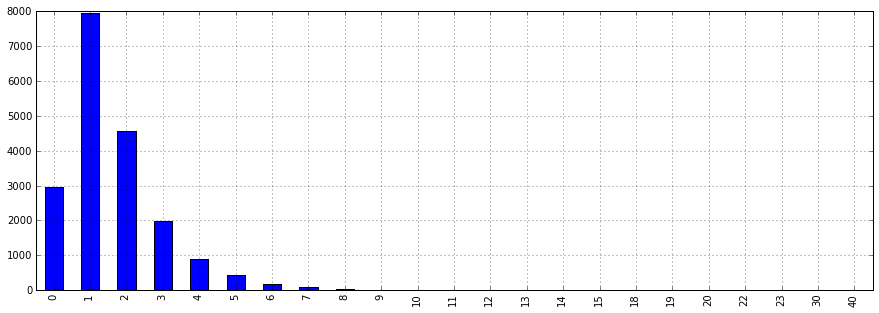

,0
0,2967
1,7940
2,4555
3,1995
4,900
5,425
6,192
7,107
8,47
9,18


In [56]:
drugDistribution = getDistinctDrugDistribution(derivedData2)
drugDistribution.index = drugDistribution.index.map(int)
drugDistribution = drugDistribution.sort_index()
ax = drugDistribution.plot(kind='bar', figsize=(15, 5), legend=False)
plt.show()
drugDistribution

In [57]:
def getStateLinesFromData(data):
    states = []
    count = {}
    
    # this varies depending on the forum 
    #inquiryDrugList = ['citalopram', 'lexapro', 'celexa', 'cipramil', 'cipralex', 'escitalopram']
    
    for index, row in data.iterrows():
        postDrugs = row['condensedDrugList']
        
#         hasUniqueDrug = False
#         for drug in postDrugs:
#             if drug not in inquiryDrugList:
#                 hasUniqueDrug = True
        
#         if hasUniqueDrug:
#             postDrugs = [drug for drug in postDrugs if drug not in inquiryDrugList]
        
        if (len(states) == 0):
            states.append(postDrugs)
            stateString = ' '.join(postDrugs)
            count[stateString] = 1
            
        isKnownState = False
        for state in states:
            stateString = ' '.join(state)
            
            if (np.array_equal(state, postDrugs)):
                isKnownState = True
                count[stateString] = count[stateString] + 1
        
        if not isKnownState:
            states.append(postDrugs)
            stateString = ' '.join(postDrugs)
            count[stateString] = 1
    
    states.remove([])
    return states, count
        

In [58]:
def printStateCountsForDrug(drug):
    print("States that start with " + drug)
    for state in stateLines:
        if state[0] == drug:
            print(state, count[' '.join(state)])
    
    print('\n')
    
    print("States that contain " + drug)
    
    for state in stateLines:
        if drug in state:
            print(state, count[' '.join(state)])

In [59]:
# Get the different medical histories and their counts

stateLines, count = getStateLinesFromData(derivedData1)
count

{'': 2968,
 'paroxetine paliperidone clomipramine olanzapine': 1,
 'diazepam duloxetine alprazolam': 2,
 'desvenlafaxine lamotrigine lisdexamfetamine': 1,
 'clonazepam paroxetine duloxetine': 2,
 'vilazodone fluoxetine': 6,
 'wellbutrin citalopram escitalopram aripiprazole sertraline': 1,
 'trilisate methylphenidate': 1,
 'sertraline zolpidem mag': 1,
 'rasagiline': 1,
 'citalopram paroxetine escitalopram fluoxetine fluvoxamine': 1,
 'sertraline zostavax': 3,
 'aripiprazole quetiapine': 5,
 'wellbutrin cyclobenzaprine fluoxetine alprazolam naprosyn': 1,
 'lamotrigine aripiprazole quetiapine zolpidem oxcarbazepine': 1,
 'lorazepam duloxetine fluoxetine propranolol': 1,
 'clonazepam desvenlafaxine fluvoxamine': 2,
 'citalopram desvenlafaxine escitalopram duloxetine sertraline': 1,
 'citalopram sertraline fluoxetine mirtazapine quetiapine venlafaxine': 1,
 'eskalith alprazolam ziprasidone augmented lisdexamfetamine lamotrigine aripiprazole': 1,
 'paroxetine duloxetine zolmitriptan methylp

In [60]:
# cell to dump the states into a text file

import json
with open('allStates.txt', 'w') as f:
    json.dump(count, f)

In [61]:
# tokenize a list of strings into component words 
def splitStringList(stringList):
    splitList = []
    for string in stringList:
        split = string.split(' ')
        splitList += split
    return splitList

In [187]:
# return dataframe of symptom counts 

def getSymptomDistributionForDrugState(drugData, drugOrState):
    filteredRows = []
    if type(drugOrState) is str:
        # we were presumably passed a drug string
        filteredRows = drugData[drugData['drugState'].astype(str).str.contains(drugOrState) ]
        
    elif type(drugOrState) is list:
        # presumably passed a drug state
        filteredRows = drugData[drugData['drugState'] == ' '.join(drugOrState)]
    
    symptomList = filteredRows['symptomState'].tolist()
    symptomTokens = splitStringList(symptomList)
    symptomFrequencies = Counter(symptomTokens)

    del symptomFrequencies['']

    top10 = symptomFrequencies.most_common(min(10, len(symptomFrequencies)))
    if len(top10) > 0:
        countThreshold = top10[len(top10) - 1][1]

        for (key, value) in symptomFrequencies.most_common():
            if value < countThreshold:
                del symptomFrequencies[key]

    df = pd.DataFrame.from_dict(symptomFrequencies, orient='index')
    return df


In [153]:
def extractSymptomListFromMappingsForDrug(filteredRows, drug):
    symptomList = []
    for index, row in filteredRows.iterrows():
        mappings = row['synonymMappings']
        if drug in mappings:
            symptomList += mappings[drug]
    return symptomList

In [154]:
def getAttributedSymptomDistributionForDrug(drugData, drug):
        
    symptomList = extractSymptomListFromMappingsForDrug(drugData, drug)
    symptomTokens = splitStringList(symptomList)
    symptomFrequencies = Counter(symptomTokens)
    
    top10 = symptomFrequencies.most_common(min(10, len(symptomFrequencies)))
    if len(top10) > 0:
        countThreshold = top10[len(top10) - 1][1]

        for (key, value) in symptomFrequencies.most_common():
            if value < countThreshold:
                del symptomFrequencies[key]

    df = pd.DataFrame.from_dict(symptomFrequencies, orient='index')
    return df


In [155]:
# lambda function for number extraction from string

def extractNumbers(string):
    if string == '':
        return ''
    else: 
        return(re.findall(r'\d+', string)[0])

In [156]:
def getDosageDistributionForDrugState(drugData, drugOrState):
    filteredRows = []
    if type(drugOrState) is str:
        # we were presumably passed a drug string
        filteredRows = drugData[drugData['drugState'].astype(str).str.contains(drugOrState) ]
        
    elif type(drugOrState) is list:
        # presumably passed a drug state
        filteredRows = drugData[drugData['drugState'] == ' '.join(drugOrState)]
    
    dosageList = filteredRows['dosageState'].tolist()
    dosageStringTokens = splitStringList(dosageList)
    dosageTokens = [extractNumbers(string) for string in dosageStringTokens]

    dosageFrequencies = Counter(dosageTokens)

    del dosageFrequencies['']
    
    top10 = dosageFrequencies.most_common(min(10, len(dosageFrequencies)))
    if len(top10) > 0:
        countThreshold = top10[len(top10) - 1][1]

        for (key, value) in dosageFrequencies.most_common():
            if value < countThreshold:
                del dosageFrequencies[key]

    df = pd.DataFrame.from_dict(dosageFrequencies, orient='index')
    return df

In [157]:
def getSymptomsAssociatedWithDosageForDrugState(drugData, drugOrState, dosage):
    filteredRows = []
    if type(drugOrState) is str:
        # we were presumably passed a drug string
        drugFiltered = drugData[drugData['drugState'].astype(str).str.contains(drugOrState)]
        filteredRows = drugFiltered[drugFiltered['dosageState'].astype(str).str.contains(dosage)]
        
    elif type(drugOrState) is list:
        # presumably passed a drug state
        drugFiltered = drugData[drugData['drugState'] == ' '.join(drugOrState)]
        filteredRows = drugFiltered[drugFiltered['dosageState'].astype(str).str.contains(dosage)]
    
    symptomList = filteredRows['symptomState'].tolist()
    symptomTokens = splitStringList(symptomList)
    symptomFrequencies = Counter(symptomTokens)

    del symptomFrequencies['']

    top10 = symptomFrequencies.most_common(min(10, len(symptomFrequencies)))
    if len(top10) > 0:
        countThreshold = top10[len(top10) - 1][1]

        for (key, value) in symptomFrequencies.most_common():
            if value < countThreshold:
                del symptomFrequencies[key]

    df = pd.DataFrame.from_dict(symptomFrequencies, orient='index')
    return df

In [158]:
def getClosestDrugForSymptomInText(drugList, symptom, text):
    drugIndexes = []
    text = text.split(' ')
    for drug in drugList:
        drugIndexes.append(text.index(drug))
        
    symptomIndex = text.index(symptom)
    
    distanceList = [abs(index - symptomIndex) for index in drugIndexes]
    closestIndex = distanceList.index(min(distanceList))
    return drugList[closestIndex]

In [159]:
def getClosestSymptomsForDrug(drugData, drug):
    symptomTokens = []
    for index, row in drugData.iterrows():
        for symptom in row['symptomList']:
            closestDrug = getClosestDrugForSymptomInText(row['drugList'], symptom, row['cleanedText'])
            if closestDrug == drug:
                symptomTokens += [symptom]
    return symptomTokens

In [160]:
def getSymptomsAssociatedWithDrug(drugData, drug):
    filteredRows = drugData[drugData['drugState'].astype(str).str.contains(drug)]
    
    symptomTokens = getClosestSymptomsForDrug(filteredRows, drug)
    symptomFrequencies = Counter(symptomTokens)

    del symptomFrequencies['']

    top10 = symptomFrequencies.most_common(min(10, len(symptomFrequencies)))
    if len(top10) > 0:
        countThreshold = top10[len(top10) - 1][1]

        for (key, value) in symptomFrequencies.most_common():
            if value < countThreshold:
                del symptomFrequencies[key]

    df = pd.DataFrame.from_dict(symptomFrequencies, orient='index')
    return df

In [161]:
allDrugsList = list(set(additionalDrugs + genericDrugNameList + brandNameDrugsList + drugList))
len(allDrugsList)

1888

In [162]:
drugName = 'venlafaxine'

In [188]:
def exportSymptomDistributionForDrug(drugName):
    symptomDistribution = getSymptomDistributionForDrugState(derivedData4, drugName)
    if not symptomDistribution.empty:
        symptomDistribution = symptomDistribution.sort([0], ascending=False)
        ax = symptomDistribution.plot(kind='bar', figsize=(15, 5), legend=False);
        ax.set_xlabel(drugName)
        ax.set_ylabel("count")
        fig = ax.get_figure()
        fig.savefig("images/" + drugName + "_all_symptoms.png")
        plt.close(fig)

In [189]:
def exportAssociatedSymptomsForDrug(drugName):
    associatedSymptomsForDrug = getSymptomsAssociatedWithDrug(derivedData4, drugName)
    if not associatedSymptomsForDrug.empty:
        associatedSymptomsForDrug = associatedSymptomsForDrug.sort([0], ascending=False)
        ax = associatedSymptomsForDrug.plot(kind='bar', figsize=(15, 5), legend=False);
        ax.set_xlabel(drugName)
        ax.set_ylabel("count")
        fig = ax.get_figure()
        fig.savefig("images/" + drugName + "_associated_symptoms.png")
        plt.close(fig)

In [190]:
def exportDosageDistributionForDrug(drugName):
    dosageDistribution = getDosageDistributionForDrugState(derivedData4, 'sertraline')
    if not dosageDistribution.empty:
        dosageDistribution.index = dosageDistribution.index.map(int)
        dosageDistribution = dosageDistribution.sort_index()
        ax = dosageDistribution.plot(kind='bar');
        fig = ax.get_figure()
        fig.savefig("images/" + drugName + "_dosages.png")
        plt.close(fig)

In [191]:
def exportAttributedSymptomDistributionForDrug(drugName):
    attributedSymptoms = getAttributedSymptomDistributionForDrug(derivedData4, drugName)
    if not attributedSymptoms.empty:
        attributedSymptoms = attributedSymptoms.sort([0], ascending=False)
        ax = attributedSymptoms.plot(kind='bar', figsize=(15, 5), legend=False);
        ax.set_xlabel(drugName)
        ax.set_ylabel("count")
        fig = ax.get_figure()
        fig.savefig("images/" + drugName + "_attributed_symptoms.png")
        plt.close(fig)

In [192]:
def exportDrugCharts(drugList):
    processedDrugsCache = set()
    
    for drug in drugList:
        if drug in cachedDrugSynonyms:
            drugSynonym = cachedDrugSynonyms[drug]
            if drugSynonym not in processedDrugsCache:
                exportSymptomDistributionForDrug(drugSynonym)
                exportAssociatedSymptomsForDrug(drugSynonym)
                exportDosageDistributionForDrug(drugSynonym)
                exportAttributedSymptomDistributionForDrug(drugSynonym)
                processedDrugsCache.add(drugSynonym)

In [193]:
exportDrugCharts(allDrugsList)

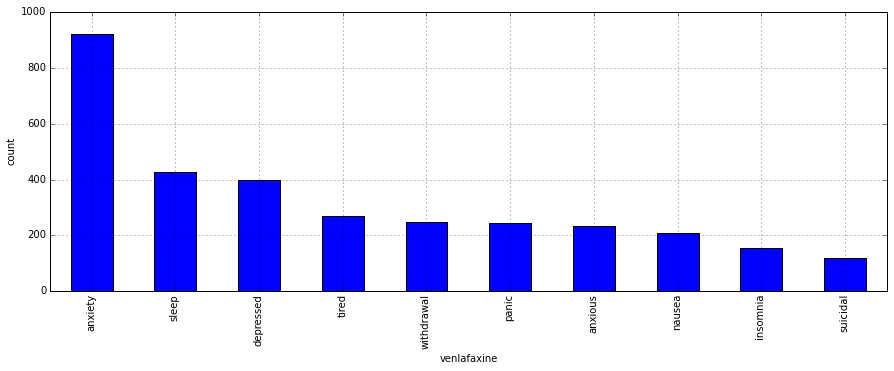

In [184]:
symptomDistribution = getSymptomDistributionForDrugState(derivedData1, drugName)
symptomDistribution = symptomDistribution.sort([0], ascending=False)
ax = symptomDistribution.plot(kind='bar', figsize=(15, 5), legend=False)
ax.set_xlabel(drugName)
ax.set_ylabel("count")
fig = ax.get_figure()
fig.savefig("images/" + drugName + "_all_symptoms.png")

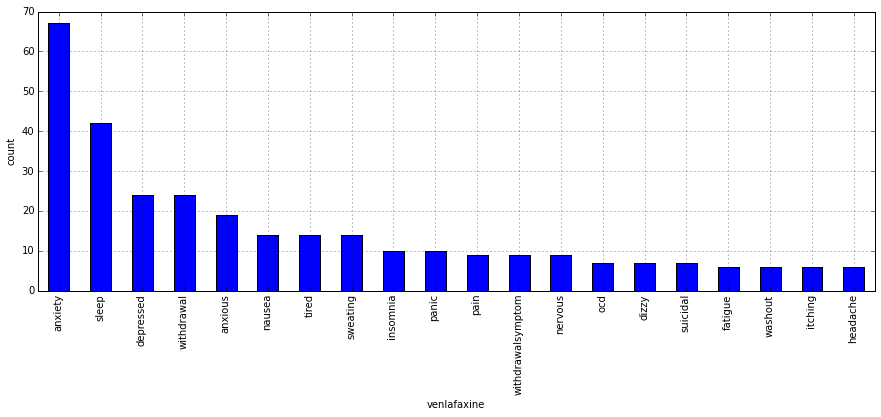

In [107]:
attributedSymptoms = getAttributedSymptomDistributionForDrug(derivedData4, drugName)
attributedSymptoms = attributedSymptoms.sort([0], ascending=False)
ax = attributedSymptoms.plot(kind='bar', figsize=(15, 5), legend=False)
ax.set_xlabel(drugName)
ax.set_ylabel("count")
#fig = ax.get_figure()
#fig.savefig("images/" + drugName + "_all_symptoms.png")
plt.show()

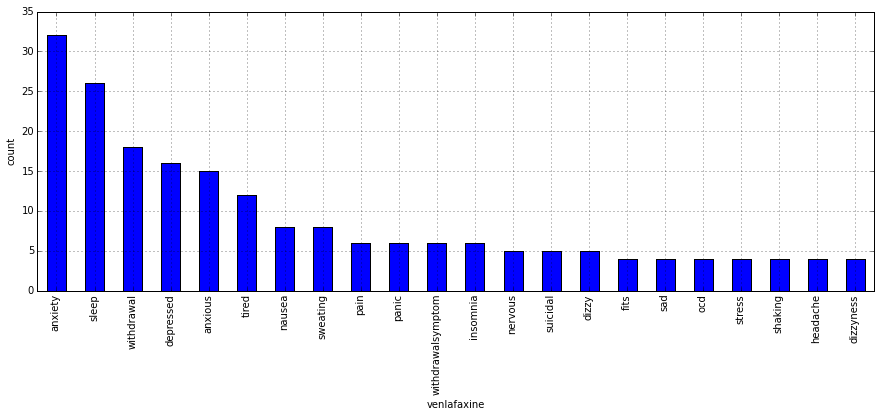

In [71]:
associatedSymptomsForDrug = getSymptomsAssociatedWithDrug(derivedData1, drugName)
associatedSymptomsForDrug = associatedSymptomsForDrug.sort([0], ascending=False)
ax = associatedSymptomsForDrug.plot(kind='bar', figsize=(15, 5), legend=False)
ax.set_xlabel(drugName)
ax.set_ylabel("count")
plt.show()

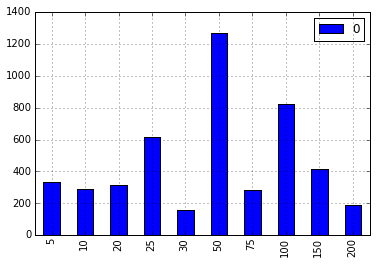

In [72]:
dosageDistribution = getDosageDistributionForDrugState(derivedData1, 'sertraline')
dosageDistribution.index = dosageDistribution.index.map(int)
dosageDistribution = dosageDistribution.sort_index()
dosageDistribution.plot(kind='bar')
plt.show()

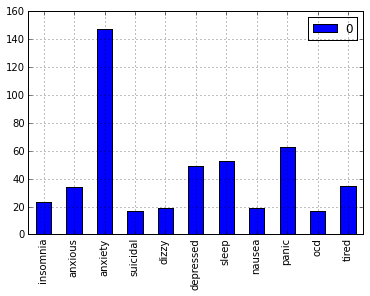

In [73]:
symptomDistributionForDosage = getSymptomsAssociatedWithDosageForDrugState(derivedData1, 'sertraline', '20mg')
symptomDistributionForDosage.plot(kind='bar')
plt.show()

In [ ]:
printStateCountsForDrug('sertraline')

In [62]:
def flatten(lst):
    rt = []
    for i in lst:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

In [57]:
def getStatesAndTransitionsForDrug_Starting(drug):
    statesStartingWithDrug = []
    for state in stateLines:
        if state[0] == drug:
            #print(state, count[' '.join(state)])
            statesStartingWithDrug.append(state)
    
    states = list(set(flatten(statesStartingWithDrug)))
    
    transitions = []
    
    for state in statesStartingWithDrug:
        for i in range(len(state) - 1):
            transition = {'trigger': '', 'source': state[i], 'dest': state[i + 1] }
            transitions.append(transition)
    
    return states, transitions

In [58]:
def getStatesAndTransitionsForDrug_Generic(drug):
    statesContainingDrug = []
    for state in stateLines:
        if drug in state:
            #print(state, count[' '.join(state)])
            statesContainingDrug.append(state)
    
    states = list(set(flatten(statesContainingDrug)))
    
    transitions = []
    
    for state in statesContainingDrug:
        for i in range(len(state) - 1):
            transition = {'trigger': '', 'source': state[i], 'dest': state[i + 1] }
            transitions.append(transition)
    
    return states, transitions

## State Machine Viz Stuff

In [54]:
from transitions import *
from transitions.extensions import GraphMachine
from IPython.display import Image, display, display_png

In [55]:
import os, sys, inspect

cmd_folder = os.path.realpath(
    os.path.dirname(
        os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0])))

if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

In [56]:
class DrugStateMachine(object):
    def is_valid(self):
        return True
    
    def is_not_valid(self):
        return False
    
    def is_also_valid(self):
        return True
    
    # graph object is created by the machine
    def show_graph(self):
        self.graph.draw('state.png', prog='dot')
        display(Image('state.png'))

In [68]:
def showDrugGraph(drug):
    states, transitions = getStatesAndTransitionsForDrug_Starting(drug)
    #states, transitions = getStatesAndTransitionsForDrug_Generic(drug)
    
    model = DrugStateMachine()
    machine = GraphMachine(model=model, 
                             states=states, 
                             transitions=transitions, 
                             auto_transitions=False, 
                             initial=drug, 
                             title=drug,
                             show_conditions=True)
    model.show_graph()

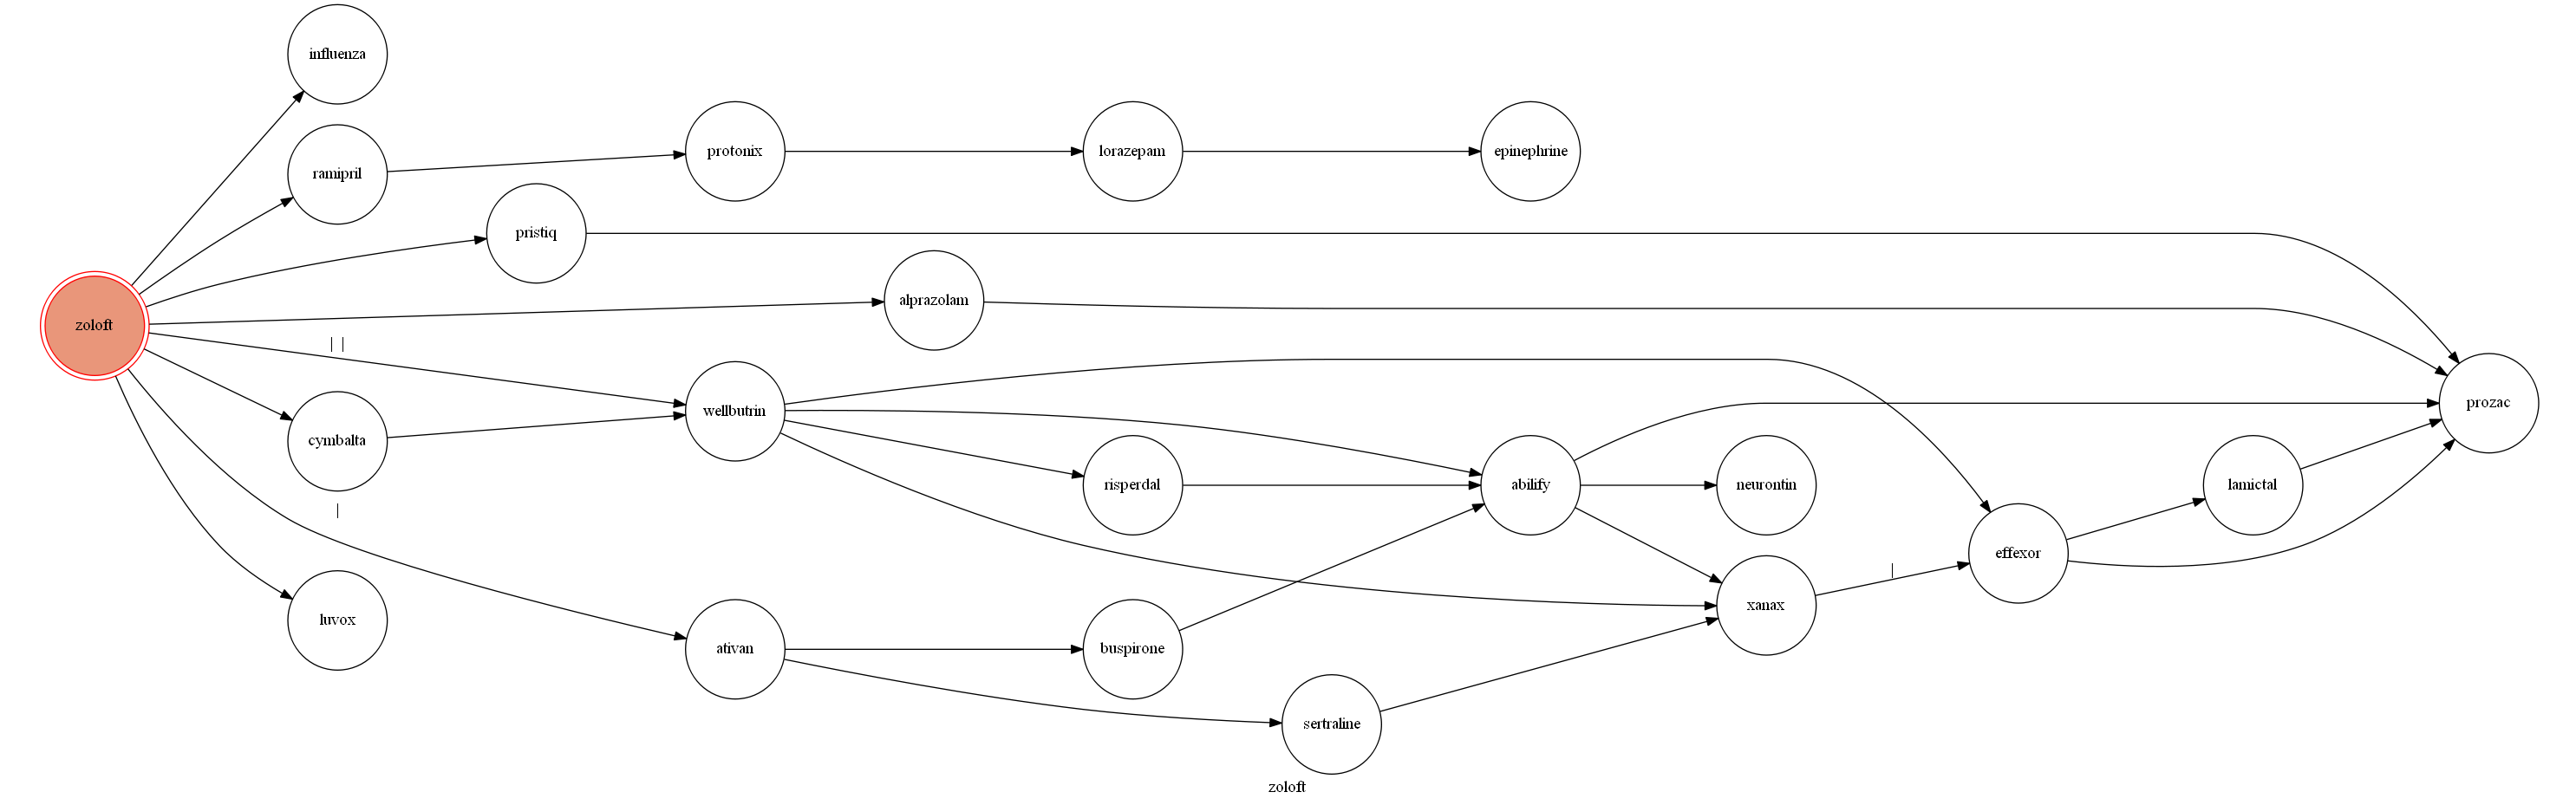

In [69]:
showDrugGraph('zoloft')

## Initialize tokenizers and stemmers

In [15]:
# create tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# conservative stop words list
en_stop = get_stop_words('en')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

texts = []

In [17]:
def strip_single_chars(tokens):
    return [i for i in tokens if len(i) > 1]

## Test on Data 

In [19]:
data = cleanedData

In [20]:
# Pre-processing for each post
for index, row in data.iterrows():
    raw = row['text'].lower()
    tokens = tokenizer.tokenize(raw)
    tokens = strip_single_chars(tokens)
    stopped_tokens = [i for i in tokens if not i in en_stop]
    stems = [p_stemmer.stem(i) for i in stopped_tokens]
    texts.append(stems)

dictionary = corpora.Dictionary(texts)

In [21]:
dictionary.token2id

{'10': 558,
 '100': 346,
 '108': 156,
 '11': 43,
 '14': 8,
 '150': 355,
 '174': 860,
 '18': 256,
 '20': 496,
 '200': 367,
 '201': 166,
 '30': 797,
 '300': 679,
 '350': 647,
 '40': 450,
 '6mg': 446,
 '80': 368,
 '800': 209,
 '900': 841,
 'abil': 418,
 'abl': 485,
 'abnorm': 248,
 'absolut': 815,
 'absorpt': 629,
 'action': 58,
 'actual': 631,
 'add': 578,
 'addit': 502,
 'adject': 53,
 'adjust': 453,
 'adult': 183,
 'advanc': 338,
 'advers': 623,
 'advic': 419,
 'affect': 214,
 'age': 51,
 'agit': 264,
 'ago': 505,
 'akasthisia': 569,
 'akathisia': 251,
 'alcohol': 266,
 'alien': 801,
 'allerg': 241,
 'allevi': 507,
 'allow': 561,
 'almost': 341,
 'aloft': 498,
 'alon': 146,
 'along': 93,
 'alreadi': 423,
 'also': 175,
 'altern': 594,
 'alway': 615,
 'amazingli': 373,
 'amount': 294,
 'anna': 511,
 'anoth': 798,
 'ant': 690,
 'anti': 527,
 'anticholinerg': 715,
 'antidepress': 31,
 'antipsychot': 98,
 'anxieti': 307,
 'anxiou': 644,
 'anyon': 336,
 'anyth': 404,
 'anyway': 494,
 'apart'

In [22]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [23]:
ldamodel = gs.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=20)

In [24]:
ldamodel.print_topics(num_topics=10, num_words=3)

[(0, '0.030*latuda + 0.020*effect + 0.019*take'),
 (1, '0.026*latuda + 0.020*help + 0.017*hope'),
 (2, '0.036*take + 0.021*week + 0.019*help'),
 (3, '0.012*anxieti + 0.012*increas + 0.012*mayb'),
 (4, '0.010*take + 0.010*good + 0.010*get'),
 (5, '0.025*take + 0.021*latuda + 0.019*depress'),
 (6, '0.019*can + 0.019*give + 0.010*latuda'),
 (7, '0.031*feel + 0.021*anxieti + 0.011*take'),
 (8, '0.038*weight + 0.038*gain + 0.028*go'),
 (9, '0.051*latuda + 0.021*take + 0.016*may')]

# Nonsense code that I'm keeping for posterity

In [48]:
count_vect = CountVectorizer(min_df=15)
testing = count_vect.fit_transform(allPostsText)

In [49]:
vocab = count_vect.get_feature_names()
vocab = np.array(vocab)

In [61]:
dtm = testing.toarray()


In [44]:
slicedCleanData['symptomList'] = slicedCleanData.apply(lambda row: extractSymptoms(row), axis=1)

ValueError: could not broadcast input array from shape (4) into shape (6)

In [ ]:
cleanedData['drugList'] = cleanedData.apply(lambda row: extractDrugNames(row), axis=1)

In [116]:
def extract(string):
    second = string.split('(')[1]
    parenWords = re.findall(r"[\w-]+", second)
    return parenWords

In [117]:
def rxlistRowSplit(row):
    drugs = row['drug']
    drugWords = re.findall(r"[\w-]+", drugs)
    
    parenWords = extract(drugs)
    #print(drugWords)
    if len(drugWords) > 0:
        row['brandNameDrug'] = drugWords[0]
        row['medicalDrugName'] = parenWords[0]

        return row
    